In [1]:
import numpy as np
import json as js
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from sklearn.decomposition import PCA

from nona.nona import nona

In [2]:
#load data


base_dir = "c:\\Users\\1\\Desktop\\datasets"
def data_loader(base_dir, max_data, start_position=0):

    data_buffer = {}

    for json_file in os.listdir(base_dir)[:-1]:

        print(json_file)
        curent_file = os.path.join(base_dir, json_file)
        curent_data_buffer = {}
        with open (curent_file) as file:

            json_data = file.readlines()
            json_data = json_data[start_position: max_data]

            for (json_number, json_per_line) in enumerate(json_data):
                
            
                json_format = js.loads(json_per_line)
                curent_data_buffer[f"subject_number: {json_number}"] = json_format
        
        data_buffer[json_file] = curent_data_buffer


    person_id_list = []
    for data_batch in data_buffer.keys():
        for subject in data_buffer[data_batch].keys():

            person_id_list.append(data_buffer[data_batch][subject]["profile_id"])


    person_log_file = os.path.join(base_dir, os.listdir(base_dir)[-1])
    person_info_buffer = {}

    with open(person_log_file) as file:

        json_data = file.readlines()
        for (json_number, json_per_line) in enumerate(json_data):

            json_format_data = js.loads(json_per_line)
            if json_format_data["id"] in person_id_list:

                person_info_buffer[json_format_data["id"]] = json_format_data
    
    return data_buffer, person_info_buffer


data_buffer, person_info_buffer = data_loader(base_dir=base_dir, max_data=2000)

keys = [key for key in person_info_buffer.keys()]
print(person_info_buffer)




activity_step_cheaters.jsonl
activity_step_ok.jsonl
{'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE': {'id': 'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE', 'birth_date': 800, 'hr_rest': 60, 'hr_max': 170, 'sex': 'female', 'weight': 76}, '0Vp2-U6casaZDBBbHDi_51q5zYC9lZid7H9bum77HZE': {'id': '0Vp2-U6casaZDBBbHDi_51q5zYC9lZid7H9bum77HZE', 'birth_date': 5600, 'hr_rest': 60, 'hr_max': 182, 'sex': 'female', 'weight': 56, 'personal_goals': ['lose_weight', 'strength', 'fun']}, 't5vblCvdKjZ2GfwvSoUwSUZUunZbkDJqyeLOEaR7qLM': {'id': 't5vblCvdKjZ2GfwvSoUwSUZUunZbkDJqyeLOEaR7qLM', 'birth_date': 1000, 'hr_rest': 60, 'hr_max': 169, 'sex': 'male', 'weight': 80, 'personal_goals': ['lose_weight']}, 'xQKE2ckX5kuzFAuiAixCOTIO3LJearvJTS1BjUVHTAU': {'id': 'xQKE2ckX5kuzFAuiAixCOTIO3LJearvJTS1BjUVHTAU', 'birth_date': 6400, 'hr_rest': 60, 'hr_max': 185, 'sex': 'male', 'weight': 90, 'personal_goals': ['strength', 'antistress', 'body_balance']}, 'OwSCFm0D2644sgzSF8zg_lplcTd735HwKcE9L8EwmDA': {'id': 'OwSCFm0D2644sg

In [3]:
def generate_data_frame(data_buffer, person_info_buffer):

    data_list = [] 
    subjects_features = ["start_millis", "stop_millis", "skllzz", 
                             "activity_day", "skllzz_with_artifacts", "skllzz_without_artifacts", 
                             "steps", "day", "meters", 
                             "birth_date", "hr_rest", "hr_max", 
                             "weight"]
    
    for (batch_number, data_batch) in enumerate(data_buffer):

        print(data_batch)
        sub_info = []
        subjects = [key for key in data_buffer[data_batch].keys()]
        subjects_id = [data_buffer[data_batch][subject]["profile_id"] for subject in subjects]

        for feature in subjects_features:
            
            subject_feature_list = []
            for (subject, subject_id) in zip(subjects, subjects_id):
                
                if feature in ["day", "meters", "steps"]:

                    if feature in data_buffer[data_batch][subject]["steps"].keys():
                        subject_feature_list.append(float(data_buffer[data_batch][subject]["steps"][feature]))

                    else:
                        subject_feature_list.append(0.0)
                
                elif feature in ["hr_max", "hr_rest", "weight", "birth_date"]:

                    if feature in person_info_buffer[subject_id].keys():
                        subject_feature_list.append(float(person_info_buffer[subject_id][feature]))
                    
                    else:
                        subject_feature_list.append(0.0)
                
                elif feature in ["stop_millis", "start_millis"]:

                    if feature in data_buffer[data_batch][subject].keys():
                        
                        formated_millis = float(data_buffer[data_batch][subject][feature]) * 3.6e+6
                        subject_feature_list.append(formated_millis)

                    else:
                        subject_feature_list.append(0.0)

                else:

                    if feature in data_buffer[data_batch][subject].keys():
                        subject_feature_list.append(float(data_buffer[data_batch][subject][feature]))
                    
                    else:
                        subject_feature_list.append(0.0)
            
            sub_info.append(subject_feature_list)
        sub_info_tensor = np.asarray(sub_info, dtype="float32")
        


        for (subject_number, subject) in enumerate(data_buffer[data_batch].keys()):

            add_vector = list(sub_info_tensor[:, subject_number]) + [batch_number, ]

            if "samples" in data_buffer[data_batch][subject]["steps"].keys():

                min_var = 1000000000000000000000000000
                samples_data = np.asarray([[float(sample[feature]) for feature in sample.keys() if feature != "duration"] for sample in data_buffer[data_batch][subject]["steps"]["samples"]])
                mean_vector = [np.mean(samples_data[:, vector_number]) for vector_number in range(samples_data.shape[1])]
                optim_vector = None

                for sample in data_buffer[data_batch][subject]["steps"]["samples"]:
                    
                    sample_vector = np.asarray([float(sample[feature]) for feature in sample.keys() if feature != "duration"])
                    if min_var > (np.dot(sample_vector, mean_vector)):

                        min_var = (np.dot(sample_vector, mean_vector))
                        optim_vector = list(sample_vector)


                optim_vector += add_vector
                optim_vector = np.asarray(optim_vector)
                optim_vector[0] *= 3.6e+6


            else:
                optim_vector = [0.0, 0.0] + add_vector
            
            data_list.append(optim_vector)



    all_features = ["stamp_millis", "steps"] + subjects_features + ["class_labels", ]
    data_tensor = np.asarray(data_list)
    data_frame = pd.DataFrame(data=data_tensor,
                              columns=all_features)
    
    return (data_frame, data_tensor)
    

data_frame, data_tensor = generate_data_frame(data_buffer=data_buffer, person_info_buffer=person_info_buffer)
print(data_frame)
            

activity_step_cheaters.jsonl
activity_step_ok.jsonl
      stamp_millis  steps  start_millis   stop_millis     skllzz   
0     6.086214e+18   10.0  6.086081e+18  6.086392e+18  48.959999  \
1     6.086392e+18   23.0  6.086392e+18  6.086703e+18  30.476000   
2     6.086820e+18   16.0  6.086703e+18  6.087014e+18  27.903999   
3     6.087147e+18   17.0  6.087014e+18  6.087325e+18  17.864000   
4     6.087425e+18   41.0  6.087325e+18  6.087636e+18  20.900000   
...            ...    ...           ...           ...        ...   
3995  6.128133e+18   11.0  6.128071e+18  6.128382e+18  29.823999   
3996  6.076750e+18   15.0  6.076750e+18  6.077061e+18  34.939999   
3997  6.139369e+18   88.0  6.139269e+18  6.139579e+18  69.031998   
3998  6.099258e+18   79.0  6.099144e+18  6.099456e+18  29.691999   
3999  6.090500e+18    2.0  6.090435e+18  6.090746e+18  62.312000   

      activity_day  skllzz_with_artifacts  skllzz_without_artifacts    steps   
0           1305.0               0.000000          

In [4]:
def mean_data_adoption(data_tensor):

    result_data_tensor = np.zeros(shape=data_tensor.shape)
    for index_i in range(data_tensor.shape[0]):
        for index_j in range(data_tensor.shape[1]):

            if (data_tensor[index_i, index_j] == 0.0) and (index_j != (data_tensor.shape[1] - 1)):

                result_data_tensor[index_i, index_j] = np.mean(data_tensor[:, index_j])

            else:

                result_data_tensor[index_i, index_j] = data_tensor[index_i, index_j]
    
    return result_data_tensor

data_tensor_mean = mean_data_adoption(data_tensor)
print(data_tensor_mean)


[[6.08621364e+18 1.00000000e+01 6.08608053e+18 ... 1.86000000e+02
  1.05000000e+02 0.00000000e+00]
 [6.08639184e+18 2.30000000e+01 6.08639170e+18 ... 1.86000000e+02
  1.05000000e+02 0.00000000e+00]
 [6.08681952e+18 1.60000000e+01 6.08670286e+18 ... 1.86000000e+02
  1.05000000e+02 0.00000000e+00]
 ...
 [6.13936908e+18 8.80000000e+01 6.13926886e+18 ... 1.80000000e+02
  1.10000000e+02 1.00000000e+00]
 [6.09925788e+18 7.90000000e+01 6.09914438e+18 ... 1.98000000e+02
  7.76999969e+01 1.00000000e+00]
 [6.09050016e+18 2.00000000e+00 6.09043515e+18 ... 1.81000000e+02
  9.70000000e+01 1.00000000e+00]]


In [97]:

def generate_data(data_buffer, person_info_buffer, max_from_samples=0.0, generation_type="all"):

    data_list = []
    for (batch_number, data_batch) in enumerate(data_buffer.keys()):

        gender_labels = {
            "male": 1.0,
            "female": 2.0
        }

        personal_goal_labels = {
            "unknown_goal": 0.0,
            "lose_weight": 1.0,
            "childrens_training": 2.0,
            "relief": 3.0,
            "strength": 4.0,
            "antistress": 5.0,
            "learn_swim": 6.0,
            "flexibility": 7.0,
            "body_balance": 8.0,
            "fun": 9.0,
            "rehabilitation": 10.0
        }

        
        for subject in data_buffer[data_batch].keys():


            curent_person_id = data_buffer[data_batch][subject]["profile_id"]
            curent_person_object = person_info_buffer[curent_person_id]
        
            
            if "samples" in data_buffer[data_batch][subject]["steps"]:
                
                
                if "skllzz_with_artifacts" in data_buffer[data_batch][subject].keys():

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        float(data_buffer[data_batch][subject]["skllzz_with_artifacts"]),
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]

                else:

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        0.0,
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]
                
                subject_pysical_data = [
                    float(data_buffer[data_batch][subject]["steps"]["steps"]),
                    float(data_buffer[data_batch][subject]["steps"]["day"]),
                    float(data_buffer[data_batch][subject]["steps"]["meters"]) / 100
                ]

                subject_personal_data = [
                    float(curent_person_object["birth_date"]) / 360,
                    float(curent_person_object["hr_rest"]),
                    float(curent_person_object["hr_max"]),
                    float(curent_person_object["weight"])
                ]

                if "personal_goals" in curent_person_object.keys():

                    subject_personal_goals = [personal_goal_labels[goal] for goal in curent_person_object["personal_goals"]]
                    if len(subject_personal_goals) != len(personal_goal_labels):

                        kernel = [personal_goal_labels["unknown_goal"] for _ in range(len(personal_goal_labels) - len(subject_personal_goals))]
                        subject_personal_goals += kernel
                
                else:

                    subject_personal_goals = [personal_goal_labels["unknown_goal"] for _ in range(len(personal_goal_labels))]
                
               

                if "skllzz_with_artifacts" in data_buffer[data_batch][subject].keys():
                    subject_general_data.append(data_buffer[data_batch][subject]["skllzz_with_artifacts"])
                
                else:
                    subject_general_data.append(0.0)
                
                add_vector = subject_general_data + subject_pysical_data + subject_personal_data + subject_personal_goals
                add_vector.append(float(batch_number))
                




                if generation_type == "per_day":

                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:

                        sample_data = [float(feature) for feature in sample.values()]
                        sample_data[0] *= (10 ** -5)
                        sample_data[1] /= 3600.0

                        sample_data += add_vector
                        
                        # if len(sample_data) == 18:

                        #     data_list.append(sample_data)
                        
                        data_list.append(sample_data)
                
                elif generation_type == "all":

                    samples_data_list = []
                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:
                        
                        sample_data = [float(feature) for feature in sample.values()]
                        sample_data[0] *= (10 ** -5)
                        sample_data[1] /= 3600.0
                        
                        samples_data_list += sample_data
                        samples_data_list += add_vector

                        data_list.append(samples_data_list)

                else:

                    raise ValueError("you must condider data generation type ['all' or 'per_daya']")



    
    if generation_type == "all":

        if max_from_samples == 0.0:

            max_sample_len = max([len(sample) for sample in data_list])

        else:

            max_sample_len = max_from_samples

        data_tensor = np.zeros(shape=(len(data_list), max_sample_len))

        for sample_number in range(data_tensor.shape[0]):

            if data_list[sample_number] != data_tensor.shape[1]:

                class_label = data_list[sample_number][-1]
                none_class_list = data_list[sample_number][:-1]
                kernel_add = [0. for _ in range((max_sample_len - len(none_class_list)) - 1)]
                
                result_vector = none_class_list + kernel_add
                result_vector.append(class_label)
                result_vector = np.asarray(result_vector)
            
            else:

                result_vector = np.asarray(data_list[sample_number])
            
            data_tensor[sample_number] = result_vector
    
    elif generation_type == "per_day":

        data_tensor = np.asarray(data_list)

    return data_tensor


data_tensor = generate_data(data_buffer=data_buffer, generation_type="per_day", person_info_buffer=person_info_buffer)
print(data_tensor, data_tensor.shape)






[[1.6906149e+07 2.5000000e+02 1.0000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.6906158e+07 2.5000000e+02 1.3000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.6906167e+07 2.5000000e+02 7.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.6918677e+07 2.5000000e+02 7.1000000e+01 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [1.6918686e+07 2.5000000e+02 7.1000000e+01 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [1.6918695e+07 2.5000000e+02 7.1000000e+01 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]] (137141, 28)


[[[1.6906149e+12 9.0000000e+05 1.0000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906158e+12 9.0000000e+05 1.3000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906167e+12 9.0000000e+05 7.0000000e+00 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[1.6906644e+12 9.0000000e+05 2.3000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906959e+12 9.0000000e+05 1.1000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906977e+12 9.0000000e+05 4.7300000e+02 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.000

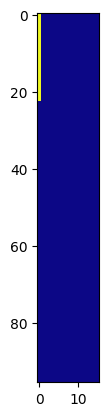

In [4]:
def simple_data_generation(data_buffer, person_info_buffer):

    data_list = []

    max_samples_number_chiters = max([len(data_buffer["activity_step_cheaters.jsonl"][subject]["steps"]["samples"]) 
                                      for subject in data_buffer["activity_step_cheaters.jsonl"].keys() 
                                      if "samples" in data_buffer["activity_step_cheaters.jsonl"][subject]["steps"].keys()])
    

    max_samples_number_none_chiters = max([len(data_buffer["activity_step_ok.jsonl"][subject]["steps"]["samples"]) 
                                           for subject in data_buffer["activity_step_ok.jsonl"].keys()
                                           if "samples" in data_buffer["activity_step_ok.jsonl"][subject]["steps"].keys()])
    

    general_max_number = max([max_samples_number_chiters, max_samples_number_none_chiters])

    for (batch_number, data_batch) in enumerate(data_buffer.keys()):
        for subject in data_buffer[data_batch].keys():
            
            curent_person_id = data_buffer[data_batch][subject]["profile_id"]
            curent_person_object = person_info_buffer[curent_person_id]

            if "samples" in data_buffer[data_batch][subject]["steps"].keys():

                if "skllzz_with_artifacts" in data_buffer[data_batch][subject].keys():

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        float(data_buffer[data_batch][subject]["skllzz_with_artifacts"]),
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]

                else:

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        0.0,
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]
                
                subject_pysical_data = [
                    float(data_buffer[data_batch][subject]["steps"]["steps"]),
                    float(data_buffer[data_batch][subject]["steps"]["day"]),
                    float(data_buffer[data_batch][subject]["steps"]["meters"]) / 100
                ]

                subject_personal_data = [
                    float(curent_person_object["birth_date"]) / 360,
                    float(curent_person_object["hr_rest"]),
                    float(curent_person_object["hr_max"]),
                    float(curent_person_object["weight"])
                ]
                
                add_vector = subject_general_data + subject_pysical_data + subject_personal_data + [batch_number, ]
                samples = [[float(feature) for feature in samples.values()] + add_vector for samples in data_buffer[data_batch][subject]["steps"]["samples"]]
                

                if len(samples) != general_max_number:

                    kernel = [[0.0 for _ in range(len(samples[0]))]  for _ in range(general_max_number - len(samples))]
                    samples += kernel
                
                data_list.append(samples)
                
    
    data_tensor = np.asarray(data_list)
    return data_tensor

data_tensor = simple_data_generation(data_buffer=data_buffer, person_info_buffer=person_info_buffer)
print(data_tensor, data_tensor.shape)

#plt.imshow(data_tensor[0], cmap="magma")
plt.imshow(data_tensor[1], cmap="plasma")
#plt.imshow(data_tensor[23], cmap="viridis")

plt.show()

[[-0.7582425  -0.32732854  0.05566856 ... -0.53724792 -1.96621046
   1.73171708]
 [-1.05389717 -0.48293204  0.71261831 ... -0.38424671  0.15833686
   1.56752635]
 [ 0.30726504 -0.22972829 -0.26346653 ...  0.9605199   0.67560736
   0.3877847 ]
 ...
 [-2.69968108  0.5595392  -0.76075201 ...  1.48182023 -0.14637518
  -0.9757006 ]
 [ 0.39769307  1.9446293   0.74181137 ... -0.42728306  0.32638838
   0.21361736]
 [-0.72454053 -1.81053254  0.87814467 ...  2.70331115  1.01764958
  -0.90365605]] [1. 0. 1. ... 1. 0. 1.]
(2000, 100) (1999, 100)
(2000,) (1999,)


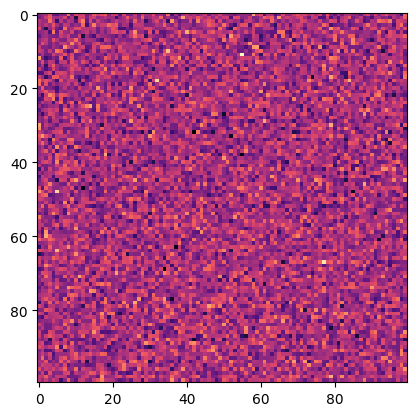

In [5]:
def expand_randomization(data_tensor, need_shape):


    permutated_data_tensor = np.random.permutation(data_tensor)

    sub_tensor = np.zeros(shape=(data_tensor[0, :-1].shape[0], need_shape))
    result_tensor = np.dot(permutated_data_tensor[:, :-1], sub_tensor)
    result_tensor += np.random.normal(0.34, 1.984, result_tensor.shape)
    result_tensor_std = (result_tensor - np.mean(result_tensor)) / np.std(result_tensor)
    result_data_tensor = np.zeros(shape=(result_tensor_std.shape[0], result_tensor_std.shape[1] + 1))
    result_data_tensor[:, :-1] = result_tensor_std
    result_data_tensor[:, -1] = permutated_data_tensor[:, -1]
    
    return result_data_tensor

preprocessed_data = expand_randomization(data_tensor, need_shape=100)

train_data = preprocessed_data[:preprocessed_data.shape[0] // 2, :-1]
validation_data = preprocessed_data[preprocessed_data.shape[0] // 2: -1, :-1]

train_label = preprocessed_data[:preprocessed_data.shape[0] // 2, -1]
validation_label = preprocessed_data[preprocessed_data.shape[0] // 2: -1, -1]

print(train_data, train_label)
print(train_data.shape, validation_data.shape)
print(train_label.shape, validation_label.shape)
plt.imshow(train_data[:100], cmap="magma")


    

[[ 3.72297422  2.65504702  3.9400577  ...  0.17131407 -1.33463674
  -1.01476446]
 [ 5.31867233  3.34422094  4.62839075 ... -1.7207867  -0.78924731
  -0.20327476]
 [ 2.04584498 -1.32682669  2.75068134 ... -0.76313507  3.88792029
   1.15370932]
 ...
 [ 1.8486556   1.04614561  0.53142299 ...  0.11187541 -2.10966836
  -1.41329799]
 [ 2.30370182 -5.73286233  3.155017   ...  1.68585621  3.0250933
   2.65760898]
 [-0.30455268  2.3910524  -1.49767148 ... -1.29448382  1.06319329
  -2.75148244]]


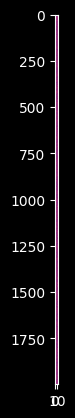

991
1009


In [27]:
data_permutated = np.random.permutation(data_tensor)


train_data = data_permutated[: data_permutated.shape[0] // 2, :-1]
train_labels = data_permutated[: data_permutated.shape[0] // 2, -1]

validation_data = data_permutated[data_permutated.shape[0] // 2: , :-1]
validation_labels = data_permutated[data_permutated.shape[0] // 2: , -1]

train_data_std = (train_data - np.mean(train_data)) / np.std(train_data)
validation_data_std = (validation_data - np.mean(validation_data)) / np.std(validation_data)

train_data_std += np.random.normal(0.34, 1.984, train_data_std.shape)
validation_data_std += np.random.normal(0.43, 1.984, validation_data_std.shape)

need_indexes_v = [index for index in range(validation_labels.shape[0]) if validation_labels[index] == 0.0]
need_indexes_t = [index for index in range(train_labels.shape[0]) if train_labels[index] == 0.0]

# pca_estimator = PCA(n_components=3)
# train_data_PCA = pca_estimator.fit_transform(train_data)
# validation_data_PCA = pca_estimator.fit_transform(validation_data)


# pca_singular_values = pca_estimator.singular_values_
# pca_explained_varience_ratio = pca_estimator.explained_variance_ratio_

# print(train_data_PCA, train_data_PCA.shape)
# print(validation_data_PCA, validation_data_PCA.shape)




#print(train_labels, train_data)
plt.imshow(train_data_std[:-1], cmap="magma")
print(train_data_std)
plt.show()
print(len(need_indexes_t))
print(len(need_indexes_v))

In [ ]:
# permutated_data_tensor = np.random.permutation(samples_data_tensor)

# train_data = permutated_data_tensor[:samples_data_tensor.shape[0] // 2, :-1]
# train_labels = permutated_data_tensor[:samples_data_tensor.shape[0] // 2, -1]

# validation_data = permutated_data_tensor[samples_data_tensor.shape[0] // 2:, :-1]
# validation_labels = permutated_data_tensor[samples_data_tensor.shape[0] // 2:, -1]

# # train_data = (train_data - np.mean(train_data)) / np.std(train_data)
# # validation_data = (validation_data - np.mean(validation_data)) / np.std(validation_data)

# print(f"Train tensor shape: {train_data.shape}, \n Test tensor shape: {validation_data.shape}")
# print(f" \nData example: {permutated_data_tensor} \n Labels example: \t{validation_labels.shape}")


In [6]:
input_tensor = tf.keras.Input(shape=(train_data.shape[1], ))

print(train_data.shape)

layer = tf.keras.layers.Dense(100, 
                              input_shape=(preprocessed_data.shape[0], ), 
                              activation="relu",
                              activity_regularizer=tf.keras.regularizers.L1(0.01),
                              kernel_regularizer=tf.keras.regularizers.L2(0.01))(input_tensor)

layer = tf.keras.layers.Dense(32, 
                              activation="relu",
                              activity_regularizer=tf.keras.regularizers.L1(0.01),
                              kernel_regularizer=tf.keras.regularizers.L2(0.01))(layer)

layer = tf.keras.layers.Dropout(0.5)(layer)
last_layer = tf.keras.layers.Dense(1, activation="sigmoid")(layer)

model = tf.keras.Model(input_tensor, last_layer)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


(2000, 100)


In [7]:
print(train_data.shape, train_label.shape)
print(validation_data.shape, validation_label.shape)
model_history = model.fit(train_data, train_label,
                          epochs=100,
                          batch_size=30,
                          validation_data=(validation_data, validation_label))

#model.save("C:\\Users\\1\\Desktop\\ItPLanetProject2\\SavedModels\\first_model.keras")


(2000, 100) (2000,)
(1999, 100) (1999,)
Epoch 1/100
67/67 [==============================] - 1s 5ms/step - loss: 2.4247 - accuracy: 0.5065 - val_loss: 2.0869 - val_accuracy: 0.5103
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 1.8177 - accuracy: 0.5405 - val_loss: 1.5732 - val_accuracy: 0.5073
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 1.3492 - accuracy: 0.5900 - val_loss: 1.1814 - val_accuracy: 0.5088
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 1.0222 - accuracy: 0.6235 - val_loss: 0.9241 - val_accuracy: 0.5063
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.8281 - accuracy: 0.6190 - val_loss: 0.7819 - val_accuracy: 0.5023
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.7360 - accuracy: 0.6130 - val_loss: 0.7336 - val_accuracy: 0.4937
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.7071 - accuracy: 0.6175 - val_loss: 0.7

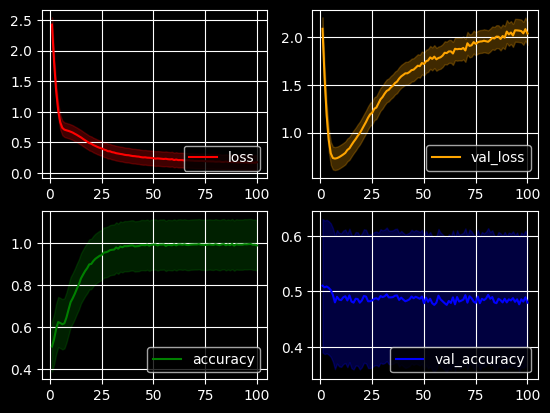

In [8]:
model_stats = [[np.asarray(model_history.history["loss"]), np.asarray(model_history.history["val_loss"])], 
          [np.asarray(model_history.history["accuracy"]), np.asarray(model_history.history["val_accuracy"])]]

def show_results(model_data):

    labels = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]
    colors = [["red", "orange"], ["green", "blue"]]

    plt.style.use("dark_background")
    fig, axis = plt.subplots(nrows=2, ncols=2)
    for sample in range(len(axis)):

        axis[sample][0].plot(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0], color=colors[sample][0], label=labels[sample][0])
        axis[sample][0].fill_between(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0] - 0.12, model_stats[sample][0] + 0.12, color=colors[sample][0], alpha=0.25)
        
        axis[sample][1].plot(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1], color=colors[sample][1], label=labels[sample][1])
        axis[sample][1].fill_between(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1] - 0.12, model_stats[sample][1] + 0.12, color=colors[sample][1], alpha=0.25)

        axis[sample][0].legend(loc="lower right")
        axis[sample][0].grid()
        
        axis[sample][1].legend(loc="lower right")
        axis[sample][1].grid()

    plt.show()

show_results(model_data=model_stats)

In [10]:

test_data_buffer, test_person_info_buffer = data_loader(base_dir="c:\\Users\\1\\Desktop\\datasets", start_position=2000, max_data=4000)
test_data_tensor = generate_data_frame(test_data_buffer, test_person_info_buffer)

test_data_frame, test_data_tensor = generate_data_frame(test_data_buffer, test_person_info_buffer)

test_preprocessed_data = expand_randomization(test_data_tensor, need_shape=100)

test_train_data = test_preprocessed_data[:test_preprocessed_data.shape[0] // 2, :-1]
test_train_labels = test_preprocessed_data[:test_preprocessed_data.shape[0] // 2, -1]

test_validation_data = test_preprocessed_data[test_preprocessed_data.shape[0] // 2:, :-1] 
test_validation_labels = test_preprocessed_data[test_preprocessed_data.shape[0] // 2:, -1]

predicted_data = model.predict(test_train_data)
chiters_number = 0
none_chiters_number = 0
errors_count = 0
true_prediction_count = 0

for (prediction_number, prediction) in enumerate(predicted_data):

    if prediction[0] > 0.55:
      
      if test_train_labels[prediction_number] == 0.0:
          errors_count += 1
      
      else:
         true_prediction_count += 1

      print(f"subject number: [{prediction_number}] is chiter with probability: [{prediction[0]}], and it's true label is: [{test_train_labels[prediction_number]}]")
      chiters_number += 1
    
    else:
      
      if test_train_labels[prediction_number] == 1.0:
          errors_count += 1
      
      else:
         true_prediction_count += 1

      print(f"subject number: [{prediction_number}] is chiter with probability: [{prediction[0]}], and it's true label is: [{test_train_labels[prediction_number]}]")
      none_chiters_number += 1
    

print(f"Total chiters number: [{chiters_number}], Total none chiters number: [{none_chiters_number}], Total prediction errors: [{errors_count}], Total prediction trues: [{true_prediction_count}]")
      




activity_step_cheaters.jsonl
activity_step_ok.jsonl
activity_step_cheaters.jsonl
activity_step_ok.jsonl
activity_step_cheaters.jsonl
activity_step_ok.jsonl
41/41 [==============================] - 0s 750us/step
subject number: [0] is chiter with probability: [0.1352575123310089], and it's true label is: [1.0]
subject number: [1] is chiter with probability: [0.2335209846496582], and it's true label is: [1.0]
subject number: [2] is chiter with probability: [0.46222174167633057], and it's true label is: [0.0]
subject number: [3] is chiter with probability: [0.7873079776763916], and it's true label is: [1.0]
subject number: [4] is chiter with probability: [0.9998064637184143], and it's true label is: [1.0]
subject number: [5] is chiter with probability: [0.09505470097064972], and it's true label is: [1.0]
subject number: [6] is chiter with probability: [0.006897616665810347], and it's true label is: [1.0]
subject number: [7] is chiter with probability: [0.7182022929191589], and it's true l

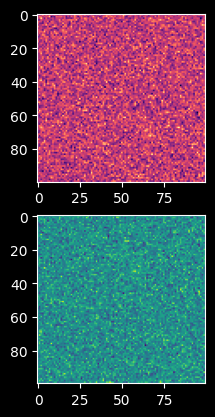

Epoch 1/100
1418/1418 [==============================] - 3s 2ms/step - loss: 0.8420 - accuracy: 0.7068 - val_loss: 0.6058 - val_accuracy: 0.7123
Epoch 2/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6045 - accuracy: 0.7113 - val_loss: 0.6015 - val_accuracy: 0.7123
Epoch 3/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6014 - accuracy: 0.7113 - val_loss: 0.6001 - val_accuracy: 0.7123
Epoch 4/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6010 - accuracy: 0.7113 - val_loss: 0.6001 - val_accuracy: 0.7123
Epoch 5/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6010 - accuracy: 0.7113 - val_loss: 0.6001 - val_accuracy: 0.7123
Epoch 6/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6010 - accuracy: 0.7113 - val_loss: 0.6001 - val_accuracy: 0.7123
Epoch 7/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6010 - accuracy: 0.7113 - val_loss: 0.6001 - val_ac

TypeError: EnsableLearningStrat.prediction() missing 2 required positional arguments: 'prediction_data_buffer' and 'prediction_personal_buffer'

In [31]:
class EnsableLearningStrat():

    # инициализация классаа 
    def __init__(self) -> None:
        self.fit_type = "E"
    


    # внесение случайного шума для имитации состязательного обучения
    def _expand_randomization(self, data_tensor, need_shape):

        permutated_data_tensor = np.random.permutation(data_tensor)

        sub_tensor = np.zeros(shape=(data_tensor[0, :-1].shape[0], need_shape))
        result_tensor = np.dot(permutated_data_tensor[:, :-1], sub_tensor)
        result_tensor += np.random.normal(0.34, 1.984, result_tensor.shape)
        result_tensor_std = (result_tensor - np.mean(result_tensor)) / np.std(result_tensor)
        result_data_tensor = np.zeros(shape=(result_tensor_std.shape[0], result_tensor_std.shape[1] + 1))
        result_data_tensor[:, :-1] = result_tensor_std
        result_data_tensor[:, -1] = permutated_data_tensor[:, -1]
        
        return result_data_tensor
        


    # генерация данных для первой нейронной сети
    def _get_samples_stats(self, data_buffer):

    
        subjects_samples_info = []
        for (batch_number, data_batch) in enumerate(data_buffer.keys()):

            for subject in data_buffer[data_batch].keys():
                
                if "samples" in data_buffer[data_batch][subject]["steps"].keys():

                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:

                        sample_tensor = [float(sample[feature]) for feature in sample.keys() if feature != "duration"] 
                        sample_tensor[0] *= 3.6e+6
                        sample_tensor.append(batch_number)

                        subjects_samples_info.append(sample_tensor)
        
        subjects_samples_info = np.asarray(subjects_samples_info)
        subject_samples_tensor = self._expand_randomization(data_tensor=subjects_samples_info, need_shape=100)

        return subject_samples_tensor



    #генерация данных для второй нейронной сети
    def _get_personal_stats(self, data_buffer, person_info_buffer):

        subjects_features = ["start_millis", "stop_millis", "skllzz", 
                             "activity_day", "skllzz_with_artifacts", "skllzz_without_artifacts", 
                             "steps", "day", "meters", 
                             "birth_date", "hr_rest", "hr_max", 
                             "weight"]
        
        subject_person_tensors = []
        for data_batch in data_buffer:

        
            sub_info = []
            subjects = [key for key in data_buffer[data_batch].keys()]
            subjects_id = [data_buffer[data_batch][subject]["profile_id"] for subject in subjects]

            for feature in subjects_features:
                
                subject_feature_list = []
                for (subject, subject_id) in zip(subjects, subjects_id):
                    
                    if feature in ["day", "meters", "steps"]:

                        if feature in data_buffer[data_batch][subject]["steps"].keys():
                            subject_feature_list.append(float(data_buffer[data_batch][subject]["steps"][feature]))

                        else:
                            subject_feature_list.append(0.0)
                    
                    elif feature in ["hr_max", "hr_rest", "weight", "birth_date"]:

                        if feature in person_info_buffer[subject_id].keys():
                            subject_feature_list.append(float(person_info_buffer[subject_id][feature]))
                        
                        else:
                            subject_feature_list.append(0.0)
                    
                    elif feature in ["stop_millis", "start_millis"]:

                        if feature in data_buffer[data_batch][subject].keys():
                            
                            formated_millis = float(data_buffer[data_batch][subject][feature]) * 3.6e+6
                            subject_feature_list.append(formated_millis)

                        else:
                            subject_feature_list.append(0.0)

                    else:

                        if feature in data_buffer[data_batch][subject].keys():
                            subject_feature_list.append(float(data_buffer[data_batch][subject][feature]))
                        
                        else:
                            subject_feature_list.append(0.0)
                
                sub_info.append(subject_feature_list)

            sub_info_tensor = np.asarray(sub_info, dtype="float32").T
            subject_person_tensors.append(sub_info_tensor)
        
        result_personal_info = np.vstack((subject_person_tensors[0], subject_person_tensors[1]))
        result_personal_tensor = self._expand_randomization(data_tensor=result_personal_info, need_shape=100)

        return result_personal_tensor



    # сбор данных для обихи нейронных сетей
    def _generate_train_data(self, data_buffer, person_info_buffer):

        self.samples_data_tensor = self._get_samples_stats(data_buffer=data_buffer)
        self.personal_data_tensor = self._get_personal_stats(data_buffer=data_buffer, person_info_buffer=person_info_buffer)
        
        samples_len = self.samples_data_tensor.shape[0]

        self.train_samples_data = self.samples_data_tensor[: samples_len // 2, :-1]
        self.train_personal_data = self.personal_data_tensor[: samples_len // 2, :-1]
        self.train_samples_labels = self.samples_data_tensor[: samples_len // 2, -1]
        self.train_personal_labels = self.personal_data_tensor[: samples_len // 2, -1]

        self.validation_samples_data = self.samples_data_tensor[samples_len // 2: , :-1]
        self.validation_personal_data = self.personal_data_tensor[samples_len // 2: , :-1]
        self.validation_samples_labels = self.samples_data_tensor[samples_len // 2: , -1]
        self.validation_personal_labels = self.personal_data_tensor[samples_len // 2: , -1]

        fig, axis = plt.subplots(nrows=2)
        axis[0].imshow(self.train_samples_data[:100, :], cmap="magma")
        axis[1].imshow(self.train_personal_data[:100, :])

        plt.show()
    
    def _generate_test_data(self, data_buffer, person_info_buffer):

        self.test_samples_data_tensor = self._get_samples_stats(data_buffer=data_buffer)
        self.test_personal_data_tensor = self._get_personal_stats(data_buffer=data_buffer, person_info_buffer=person_info_buffer)



    # генерация нейронных сетей для обучения на выборках тренировок и выборках личных данных
    def _generate_neural_network(self):

        first_model_input_tensor = tf.keras.Input(shape=(self.train_samples_data.shape[1], ))
        second_model_input_tensor = tf.keras.Input(shape=(self.train_personal_data.shape[1], ))

        first_model_layer = tf.keras.layers.Dense(100, 
                                                       input_shape=(self.samples_data_tensor, ), 
                                                       activation="relu",
                                                       activity_regularizer=tf.keras.regularizers.L1(0.01),
                                                       kernel_regularizer=tf.keras.regularizers.L2(0.01))(first_model_input_tensor)
        
        first_model_layer = tf.keras.layers.Dense(32,
                                                       input_shape=(self.samples_data_tensor, ),
                                                       activation="relu",
                                                       activity_regularizer=tf.keras.regularizers.L1(0.01),
                                                       kernel_regularizer=tf.keras.regularizers.L2(0.01))(first_model_layer)
        
        first_model_layer = tf.keras.layers.Dropout(0.5)(first_model_layer)
        first_model_last_layer = tf.keras.layers.Dense(1, activation="sigmoid")(first_model_layer)


        second_model_layer = tf.keras.layers.Dense(100,
                                                        input_shape=(self.personal_data_tensor, ),
                                                        activation="relu",
                                                        activity_regularizer=tf.keras.regularizers.L1(0.01),
                                                        kernel_regularizer=tf.keras.regularizers.L2(0.01))(second_model_input_tensor)
        
        second_model_layer = tf.keras.layers.Dense(32,
                                                        activation="relu",
                                                        activity_regularizer=tf.keras.regularizers.L1(0.01),
                                                        kernel_regularizer=tf.keras.regularizers.L2(0.01))(second_model_layer)
        
        second_model_layer = tf.keras.layers.Dropout(0.5)(second_model_layer)
        second_model_last_layer = tf.keras.layers.Dense(1, activation="sigmoid")(second_model_layer)


        first_model = tf.keras.Model(first_model_input_tensor, first_model_last_layer)
        second_model = tf.keras.Model(second_model_input_tensor, second_model_last_layer)

        first_model.compile(
            optimizer="rmsprop",
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )

        second_model.compile(
            optimizer="rmsprop",
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )

        return (first_model, second_model) 
    


    
    #TODO добавить функцию обучения нейронной сети
    def fit_simple(self):

        self.fit_type = "NE"
        first_model, second_model = self._generate_neural_network()

        first_model_history = first_model.fit(self.train_samples_data, self.train_samples_labels,
                             batch_size=30,
                             epochs=100,
                             validation_data=(self.validation_samples_data, self.validation_samples_labels))

        second_model_history = second_model.fit(self.train_personal_data, self.train_personal_labels,
                              batch_size=30,
                              epochs=100,
                              validation_data=(self.validation_personal_data, self.validation_personal_labels))
        
        self.models_history = [first_model_history, second_model_history]
        self.models = [first_model_history, second_model_history]
    

    def fit_bagging(self, number_of_blocks):
        
        self.fit_type = "E"

        self.models_history = []
        self.models = []

        block_size_samples = self.train_samples_data.shape[0] // number_of_blocks
        block_size_personal = self.train_personal_data.shape[0] // number_of_blocks

        for block in range(number_of_blocks):

            samples_model, personal_model = self._generate_neural_netrwork()
            self.models.append([samples_model, personal_model])

            batch_of_samples_data = self.train_samples_data[block * block_size_samples: (block + 1) * block_size_samples, :-1]
            batch_of_samples_labels = self.train_samples_data[block * block_size_samples: (block + 1) * block_size_samples, -1]
          
            batch_of_personal_data = self.train_personal_data[block * block_size_personal: (block + 1) * block_size_personal, :-1]
            batch_of_personal_labels = self.train_personal_data[block * block_size_personal: (block + 1) * block_size_personal, -1]

            samples_model_history = samples_model.fit(batch_of_samples_data, batch_of_samples_labels,
                                  batch_size=30,
                                  epochs=100),
            
            personal_model_history = personal_model.fit(batch_of_personal_data, batch_of_personal_labels,
                                batch_size=30,
                                epochs=100)
            
            self.models_history.append([samples_model_history, personal_model_history])


    

    def prediction(self, prediction_data_buffer, prediction_personal_buffer):
        
        self._generate_test_data(data_buffer=prediction_data_buffer, person_info_buffer=prediction_personal_buffer)

        if self.fit_type == "NE":
            
            predicted_samples = self.models[0].predict(self.test_samples_data_tensor)
            predicted_personals = self.models[1].predict(self.test_personal_data_tensor)

            marks_samples = np.asarray([sample_mark[0] for sample_mark in predicted_samples])
            marks_personals = np.asarray([personal_mark[1] for personal_mark in predicted_personals])

            self.result_estimation = 0.5 * (marks_samples + marks_personals)

        elif self.fit_type == "E":

            #TODO доделать предиктор ансамбля сетей
            self.samples_marks = []
            self.personal_marks = []

            for block_models in self.models:

                predicted_samples = block_models[0].predict(self.test_samples_data_tensor)
                predicted_personals = block_models[1].predict(self.test_personal_data_tensor)

                marks_samples = np.asarray([sample_mark[0] for sample_mark in predicted_samples])
                marks_personals = np.asarray([personal_mark[0] for personal_mark in predicted_personals])

                self.samples_marks.append(marks_samples)
                self.personal_marks.append(marks_personals)
            
            self.mean_predicted_samples = np.zeros(shape=self.samples_marks[0].shape)
            self.mean_predicted_personals = np.zeros(shape=self.personal_marks[0].shape)

            for (curent_predicted_samples, curent_predicted_personals) in zip(self.samples_marks, self.personal_marks):

                self.mean_predicted_personals += curent_predicted_personals
                self.mean_predicted_samples += curent_predicted_samples
            
            self.mean_predicted_personals = self.mean_predicted_personals / len(self.samples_marks)
            self.mean_predicted_samples = self.mean_predicted_samples / len(self.personal_marks)

            self.result_estimation = 0.5 * (self.mean_predicted_personals + self.mean_predicted_samples)
        
        
        return self.result_estimation

neo_trainer = EnsableLearningStrat()
neo_trainer._generate_train_data(data_buffer=test_data_buffer, person_info_buffer=test_person_info_buffer)
neo_trainer.fit_simple()
result_prediction = neo_trainer.prediction()

print(result_prediction)
        
